# AE를 이용한 이상치검출 (Anomaly Detection)

## 1. 라이브러리 임포트

In [13]:
#텐서플로, numpy, matplotlib의 라이브러리 임포트
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

#MNIST 모듈 임포트
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## 2. Mnist train/test 분류
Mnist는 원래 2가지 파일로 구성되어 있음
  1. mnist.train : 0~9까지 60,000개 이미지 
  2. mnist.test  : 0~9까지 10,000개 이미지

## ■ 테스트 이미지 파일 생성
1. mnist.train  
 1) train_idx  - trian 이미지 중 1~9의 숫자 그림으로 구성 : 오토인코더 학습 & 임계치 결정  
 2) train0_idx - train 이미지 중 0인 숫자 그림으로 구성 : 임계치 결정 
2. mnist.test  
 1) test19_idx - test 이미지 중 1~9의 숫자 그림으로 구성 : test 데이터  
 2) test0_idx  - test 이미지 중 0인 숫자 그림으로 구성 : test 데이터

In [14]:
# np.argmax : 배열중에 가장 큰 수를 뽑아냄, labels에서 숫자 확인 가능
# 예시) lables가 [0,0,1,0,0,0,0,0,0,0] 이면 2로 값이 나오게 됨
train_idx = ((np.argmax(mnist.train.labels, 1) == 1) | \
             (np.argmax(mnist.train.labels, 1) == 2) | \
             (np.argmax(mnist.train.labels, 1) == 3) | \
             (np.argmax(mnist.train.labels, 1) == 4) | \
             (np.argmax(mnist.train.labels, 1) == 5) | \
             (np.argmax(mnist.train.labels, 1) == 6) | \
             (np.argmax(mnist.train.labels, 1) == 7) | \
             (np.argmax(mnist.train.labels, 1) == 8) | \
             (np.argmax(mnist.train.labels, 1) == 9))
train0_idx = (np.argmax(mnist.train.labels, 1) == 0)

#test_set 정리
test19_idx = ((np.argmax(mnist.test.labels, 1) == 1) | \
              (np.argmax(mnist.test.labels, 1) == 2) | \
              (np.argmax(mnist.test.labels, 1) == 3) | \
              (np.argmax(mnist.test.labels, 1) == 4) | \
              (np.argmax(mnist.test.labels, 1) == 5) | \
              (np.argmax(mnist.test.labels, 1) == 6) | \
              (np.argmax(mnist.test.labels, 1) == 7) | \
              (np.argmax(mnist.test.labels, 1) == 8) | \
              (np.argmax(mnist.test.labels, 1) == 9))
test0_idx = (np.argmax(mnist.test.labels, 1) == 0)


train_imgs    = mnist.train.images[train_idx] # 1~9까지 train 이미지 추출
train_labels  = mnist.train.labels[train_idx] # 1~9까지 train 라벨 추출
train0_imgs   = mnist.train.images[train0_idx] # 0만 train 이미지 추출
train0_labels = mnist.train.labels[train0_idx] # 0만 train 라벨 추출
test19_imgs   = mnist.test.images[test19_idx] # 1~9까지 test 이미지 추출
test19_labels = mnist.test.labels[test19_idx] # 1~9까지 test 라벨 추출
test0_imgs    = mnist.test.images[test0_idx] # 0만 test 이미지 추출
test0_labels  = mnist.test.labels[test0_idx] # 0만 test 라벨 추출
n_train       = train_imgs.shape[0] # 1~9까지 train 이미지 shape 변경
n_train0      = train0_imgs.shape[0] # 0만 train 이미지 shape 변경
n_test19      = test19_imgs.shape[0] # 1~9까지 test 이미지 shape 변경
n_test0       = test0_imgs.shape[0] # 0만 test 이미지 shape 변경

print ("The number of training(1~9) images : {}, shape : {}".format(n_train, train_imgs.shape))
print ("The number of training(0) images : {}, shape : {}".format(n_train0, train0_imgs.shape))
print ("The number of testing(1~9) images() : {}, shape : {}".format(n_test19, test19_imgs.shape))
print ("The number of testing(0) images : {}, shape : {}".format(n_test0, test0_imgs.shape))

The number of training(1~9) images : 49556, shape : (49556, 784)
The number of training(0) images : 5444, shape : (5444, 784)
The number of testing(1~9) images() : 9020, shape : (9020, 784)
The number of testing(0) images : 980, shape : (980, 784)


## 3. 옵션설정

In [15]:
learning_rate = 0.01 #최적화 함수에서 사용할 학습률
training_epoch = 20  #전체 데이터를 학습할 총 횟수
batch_size = 100     #미니배치로 한번에 학습할 데이터(이미지)의 갯수
n_hidden = 256       #은닉층의 뉴런 개수
n_input = 28*28      #이미지 크기 28*28 = 784

## 4. 모델구성

In [16]:
# X라는 플레이스 홀더를 설정
X = tf.placeholder(tf.float32, [None, n_input])

# ENCODER 인코더, n_hidden개의 뉴런을 가진 은닉층 만듬
W_encode = tf.Variable(tf.random_normal([n_input, n_hidden]))  #n_hidden개의 뉴런을 가진 은닉층 만듬
b_encode = tf.Variable(tf.random_normal([n_hidden])) 
encoder = tf.nn.sigmoid(tf.add(tf.matmul(X,W_encode),b_encode)) #sigmoid 활성화 함수 적용

# DECODER 디코더 (n_input과 n_hidden을 인코더와 반대로 입력)
W_decode = tf.Variable(tf.random_normal([n_hidden, n_input]))
b_decode = tf.Variable(tf.random_normal([n_input]))
decoder = tf.nn.sigmoid(tf.add(tf.matmul(encoder,W_decode),b_decode))

## 5. 모델학습
### 손실함수
입력값과 출력값의 차이를 최소화함 (복원 오차 최소화)

\begin{align}
\frac{1}{m}\sum_i^m{(x_i-y_i)}^2
\end{align}

In [17]:
#손실함수(두 값의 거리차이) = X(평가하기 위한 실측값) - 디코더의 결과값
cost = tf.reduce_mean(tf.pow(X-decoder,2))

#최적화 함수 RMSPropOptimizer로 cost를 최소화 함
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

#train(1~9)에 해당하는 그림만을 가지고 batch할 수 있는 함수 생성
def train_batch_maker(batch_size):
     random_idx = np.random.randint(n_train, size = batch_size)
     return train_imgs[random_idx], train_labels[random_idx]

#학습진행
init = tf.global_variables_initializer() #변수 초기화
sess = tf.Session() # Session 오픈
sess.run(init) # 텐서플로우로 변수들 초기화 완료(학습 진행 준비 완료)

total_batch = int(n_train/batch_size) #배치 갯수

for epoch in range(training_epoch): 
    total_cost = 0
    
    for i in range(total_batch):
        batch_xs, batch_ys = train_batch_maker(batch_size)
        _, cost_val = sess.run([optimizer, cost], feed_dict={X:batch_xs})
        total_cost += cost_val
        
    print('Epoct:', '%04d' % (epoch + 1), 'Avg. cost = ', '{:.4f}'.format(total_cost/total_batch))

print('최적화 완료!')


Epoct: 0001 Avg. cost =  0.2103
Epoct: 0002 Avg. cost =  0.0657
Epoct: 0003 Avg. cost =  0.0539
Epoct: 0004 Avg. cost =  0.0477
Epoct: 0005 Avg. cost =  0.0431
Epoct: 0006 Avg. cost =  0.0398
Epoct: 0007 Avg. cost =  0.0373
Epoct: 0008 Avg. cost =  0.0352
Epoct: 0009 Avg. cost =  0.0342
Epoct: 0010 Avg. cost =  0.0335
Epoct: 0011 Avg. cost =  0.0330
Epoct: 0012 Avg. cost =  0.0323
Epoct: 0013 Avg. cost =  0.0313
Epoct: 0014 Avg. cost =  0.0294
Epoct: 0015 Avg. cost =  0.0289
Epoct: 0016 Avg. cost =  0.0287
Epoct: 0017 Avg. cost =  0.0285
Epoct: 0018 Avg. cost =  0.0282
Epoct: 0019 Avg. cost =  0.0270
Epoct: 0020 Avg. cost =  0.0267
최적화 완료!


## 6.1 Normal data 복원 확인 (Testing data)

Training data cost =  0.0284


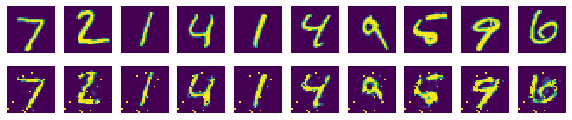

In [18]:
sample_size = 10 #샘플로 볼 이미지 갯수 지정

# 텐서플로우로 test 이미지(1~9)까지 DECODER로 학습진행
samples19 = sess.run(decoder, feed_dict={X:test19_imgs[:sample_size]}) 
print('Training data cost = ', '{:.4f}'.format(sess.run(cost, feed_dict={X:test19_imgs[:sample_size]})))

fig, ax = plt.subplots(2, sample_size, figsize=(sample_size, 2))

for i in range(sample_size):
    ax[0][i].set_axis_off()
    ax[1][i].set_axis_off()
    ax[0][i].imshow(np.reshape(test19_imgs[i], (28,28)))
    ax[1][i].imshow(np.reshape(samples19[i], (28,28)))

plt.show()

## 6.2 Abnormal data 복원 확인 (Testing data)

Testing data cost =  0.0396


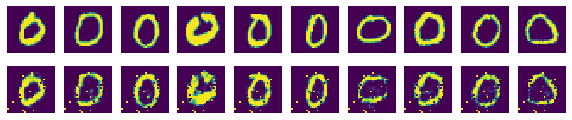

In [19]:
sample_size = 10 #샘플로 볼 이미지 갯수 지정

# 텐서플로우로 test이미지(0만)까지 DECODER로 학습진행
samples0 = sess.run(decoder, feed_dict={X:test0_imgs[:sample_size]})
print('Testing data cost = ', '{:.4f}'.format(sess.run(cost, feed_dict={X:test0_imgs[:sample_size]})))

fig, ax = plt.subplots(2, sample_size, figsize=(sample_size, 2))

for i in range(sample_size):
    ax[0][i].set_axis_off()
    ax[1][i].set_axis_off()
    ax[0][i].imshow(np.reshape(test0_imgs[i], (28,28))) 
    ax[1][i].imshow(np.reshape(samples0[i], (28,28)))

plt.show()

## 7. Confusion Matrix(오차행렬)
### 참이라고 간주되는 관측값과 평가를 위해 추출된 샘플간의 비교를 위한 행렬
### 참고 : https://en.wikipedia.org/wiki/Confusion_matrix
### 참고 : https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/

## 7.1 Test data의 실제값(y_true) 라벨링하기
### 이미지별 라벨값이 0이면 Anomaly인 0의 값, 라벨값이 1~9면 normal인 1의 값을 입력

In [20]:
all_size = int(len(mnist.test.labels)*0.1) #test 전체 갯수 : 10,000개 중 10%만 사용

y_true = [] #y_true list 초기화 

for i in range(all_size): # 1~10,000까지 반복함
    if np.argmax(mnist.test.labels[i]) == 0: #라벨값이 0인지 아닌지 확인하는 조건문
        y_true.insert(i, 0) #라벨값이 0이면 Anomaly
    else:
        y_true.insert(i, 1) #라벨값이 0이 아니면 normal (1~9까지는 1로)

print(y_true[0:100]) #프린트로 값을 확인할 수 있다 (확인용으로 100개만).

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


## 7.2 Test data의 예측값(y_pred) 구하기 (AE 통과하기)

### cost의 측정지표(통계값)
train 1~9까지의 이미지 데이터의 Cost값과  
train 0의 이미지 데이터의 Cost 값을 비교하여 임계값을 설정한다.  
※ 연구 주제에 따라 임계값 설정 방법은 변경 될 수 있음

In [22]:
import pandas as pd #판다스 라이브러리 임포트
import random #random 함수 관련 라이브러리 임포트

train_size = int(len(train_imgs)*0.1) # train 1~9까지 이미지 갯수 : 49556 중에 10%만 확인
train0_size = int(len(train0_imgs)*0.1) # train 0의 이미지 갯수 : 5444 중에 10%만 확인

train_cost=[] # 초기화
for i in range (train_size): # train 1~9까지의 Cost 값 계산
    ind_cost = tf.reduce_mean(tf.pow(X[i]-decoder[i],2))
    train_cost.append(ind_cost)
    
train0_cost=[] # 초기화 
for i in range (train0_size): # train 0의 Cost 값 계산
    ind_cost = tf.reduce_mean(tf.pow(X[i]-decoder[i],2))
    train0_cost.append(ind_cost)



### Histogram 그려보기

train19_median : 0.0243
train0_median : 0.0400


Train19_Cost Metric
       Train19_Cost
count   4955.000000
mean       0.026246
std        0.008967
min        0.011865
25%        0.020015
50%        0.024339
75%        0.030645
max        0.083961


Train0_Cost Metric
       Train0_Cost
count   544.000000
mean      0.042016
std       0.013841
min       0.017020
25%       0.030920
50%       0.040006
75%       0.052300
max       0.086083




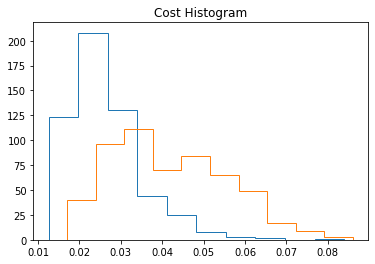

In [26]:
def test_median(): #통계지표 구하는 함수 생성
    cost19 = sess.run(train_cost, feed_dict={X:train_imgs})   # 텐서플로우 실행하여 train 1~9까지의 Cost값 계산하기
    cost0  = sess.run(train0_cost, feed_dict={X:train0_imgs}) # 텐서플로우 실행하여 train 0의 Cost값 계산하기
    
    median19 = np.median(cost19) #중앙값 구하는 함수
    print('train19_median :', '{:.4f}'.format(median19)) 
    median0 = np.median(cost0) #중앙값 구하는 함수
    print('train0_median :', '{:.4f}'.format(median0)) 
    
    print('\n')
    print('Train19_Cost Metric')
    cost19_df = pd.DataFrame({'Train19_Cost':cost19}) #기초통계학 평균, 분산, 최소값, 최대값, 25%, 50%, 75% 분포 구하는 함수
    print(cost19_df.describe())
    
    print('\n')
    print('Train0_Cost Metric')
    cost0_df = pd.DataFrame({'Train0_Cost':cost0}) #기초통계학 평균, 분산, 최소값, 최대값, 25%, 50%, 75% 분포 구하는 함수
    print(cost0_df.describe())
    
    print('\n')
    plt.figure()
    plt.title('Cost Histogram') # 그림 이름 설정 
    rd_cost19 = random.sample(cost19, train0_size) # train 1~9의 Cost 중 train 0과 같은 5,444개의 데이터를 랜덤 샘플링 (중복없음)
    plt.hist(rd_cost19, bins=10, facecolor='blue', histtype='step') #히스토그램 함수, bins:데이터를 범주화 하는 기준
    plt.hist(cost0, bins=10, facecolor='red', histtype='step') #히스토그램 함수, bins:데이터를 범주화 하는 기준
    plt.show()    
    
test_median() #함수실행

### cost의 중앙값(median)을 임계점으로 설정, 각 그림별 Cost가 임계점보다 높으면 positive(이상), 낮으면 negative(정상)

In [29]:
# 각 이미지별 cost를 구하여 설정한 임계값으로 조건을 제시한다.
all_cost=[]

for i in range(all_size):
    ind_cost = tf.reduce_mean(tf.pow(X[i]-decoder[i],2))
    all_cost.append(ind_cost)
    
ind_cost = sess.run(all_cost, feed_dict={X:mnist.test.images}) # 텐서플로우 실행하여 Cost값 계산

threshold = 0.04  # 설정한 임계값 (선택 가능)

y_pred = [] #y_pred list 초기화
for i in range(all_size):
    if ind_cost[i] > threshold :
        y_pred.insert(i, 0) #임계점보다 높으면 positive(이상)
    else:
        y_pred.insert(i, 1) #임계점보다 낮으면 negative(정상)
        
print(y_pred[0:100]) #프린트로 값을 확인할 수 있다 (확인용으로 100개만).

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


## 7.3 Confusion_matrix 계산하기


 TP : 39 
 FN : 46 
 FP : 68 
 TN : 847 

Accuracy(정분류율=(TP+TN)/(TP+FN+FP+TN)): 0.8860
Error_rate(오분류율=(FP+FN)/(TP+FN+FP+TN): 0.1140
Precirion(정확도=TP/(TP+FP)): 0.3645
Recall(재현율,민감도=TP/(TP+FN)): 0.4588




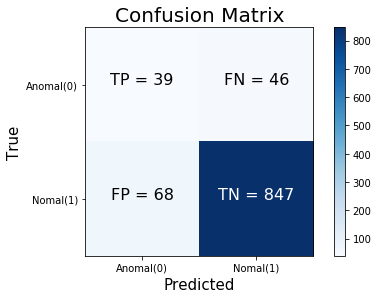

In [30]:
cm = tf.confusion_matrix(y_true, y_pred) #confusion_matrix 함수 실행
con_mat = sess.run(cm) #텐서플로우 실행 후 con_mat으로 입력
    
# Print the confusion matrix as text.
TP = con_mat[0][0] #둘다 Anomal, 0이며 예측값이 positive(이상값)이다.
FN = con_mat[0][1] #실제값과 예측값이 달랐으며, 예측값이 negative(정상값)이다.
FP = con_mat[1][0] #실제값과 예측값이 달랐으며, 예측값이 postive(이상값)이다.
TN = con_mat[1][1] #둘다 nomal, 1이며 예측값이 negative(정상값)이다.
print('\n',
      'TP :', TP, '\n', 
      'FN :', FN, '\n', 
      'FP :', FP, '\n', 
      'TN :', TN, '\n')

Accuracy = (TP+TN)/(TP+FN+FP+TN) #정분류율 : 전체관측치 중 실제값과 예측치가 일치하는 정도
print('Accuracy(정분류율=(TP+TN)/(TP+FN+FP+TN)):', '{:.4f}'.format(Accuracy))

Error_rate = (FP+FN)/(TP+FN+FP+TN) #오분류율 : 전체 관측치 중 실제값과 예측치가 다른 정보 (1-accuracy)
print('Error_rate(오분류율=(FP+FN)/(TP+FN+FP+TN):', '{:.4f}'.format(Error_rate))

Precirion = TP/(TP+FP) #정확도 : TRUE로 예측한 관측치 중 실제값이 TRUE인 정도
print('Precirion(정확도=TP/(TP+FP)):', '{:.4f}'.format(Precirion))

Recall = TP/(TP+FN) #재현율 : 실제값이 TRUE인 관측치 중 예측치가 적중한 정도, 모형의 완정성을 평가함, 민감도
print('Recall(재현율,민감도=TP/(TP+FN)):', '{:.4f}'.format(Recall))

print('\n')
# Confusion Matrix 표 그리기
plt.imshow(con_mat, interpolation='nearest', cmap=plt.cm.Blues)

# Plot 구성하기
plt.title('Confusion Matrix', fontsize=20) # Plot 이름
plt.tight_layout()
plt.colorbar()
label=["Anomal(0)", "Nomal(1)"] # 라벨값
tick_marks = np.arange(len(label)) 
plt.xticks(tick_marks, label)
plt.yticks(tick_marks, label)
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('True', fontsize=15)
# 표 안에 숫자 기입하는 방법
name = [['TP','FN'], ['FP', 'TN']]
thresh = con_mat.max() / 2.
for i in range(2):
     for j in range(2):
        plt.text(j, i, str(name[i][j])+" = "+str(con_mat[i, j]),
                 horizontalalignment="center",
                 color="white" if con_mat[i, j] > thresh else "black",
                 fontsize=16)
    
plt.show()